<a href="https://colab.research.google.com/github/cvt220106/google-colab/blob/main/tf03_keras_classification_model_separable_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.8.2
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.2
keras.api._v2.keras 2.8.0


In [15]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
# reshape最后的1时增添通道维数,从而满足卷积神经网络的输入


In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                              padding='same',
                              activation='selu',
                              input_shape=(28, 28, 1)))
#这里就是深度可分离卷积--SeparableConv2D
model.add(keras.layers.SeparableConv2D(filters=32, kernel_size=3,
                                       padding='same',
                                       activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.SeparableConv2D(filters=64, kernel_size=3,
                                       padding='same',
                                       activation='selu'))
model.add(keras.layers.SeparableConv2D(filters=64, kernel_size=3,
                                       padding='same',
                                       activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.SeparableConv2D(filters=128, kernel_size=3,
                                       padding='same',
                                       activation='selu'))
model.add(keras.layers.SeparableConv2D(filters=128, kernel_size=3,
                                       padding='same',
                                       activation='selu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='selu'))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

深度可分离神经网络下,能够有效减少参数个数,并且不损失太多的准确率<br>
具体参数计算方式为:
> 卷积核大小(3x3)x上一层的输出层数+上一层的输出层数*当前层的卷积核数(通道数)+当前层的卷积核数(bias)<br>
> 1344=(3x3)x32+32x32+32<br>
> 2400=(3x3)x32+32x64+64<br>

在忽略掉bias的情况下,计算一下深度可分离网络的参数压缩率<br>
记卷积核大小为Dk,上一层的输出层数为M,当前层的卷积核数为N
> Dk^2xM+MxN/Dk^2xMxN=1/N+1/Dk^2

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 separable_conv2d_5 (Separab  (None, 28, 28, 32)       1344      
 leConv2D)                                                       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 separable_conv2d_6 (Separab  (None, 14, 14, 64)       2400      
 leConv2D)                                                       
                                                                 
 separable_conv2d_7 (Separab  (None, 14, 14, 64)       4736      
 leConv2D)                                            

In [19]:
# model.variables

In [20]:
model.layers

In [21]:
logdir = './separable-cnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1719/1719 [==============================] - 9s 5ms/step - loss: 2.3018 - accuracy: 0.1081 - val_loss: 2.2980 - val_accuracy: 0.1296
Epoch 2/100
1719/1719 [==============================] - 8s 5ms/step - loss: 1.5475 - accuracy: 0.4602 - val_loss: 0.8100 - val_accuracy: 0.6962
Epoch 3/100
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7326 - accuracy: 0.7263 - val_loss: 0.6550 - val_accuracy: 0.7586
Epoch 4/100
1719/1719 [==============================] - 11s 7ms/step - loss: 0.6300 - accuracy: 0.7645 - val_loss: 0.5860 - val_accuracy: 0.7740
Epoch 5/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5554 - accuracy: 0.7907 - val_loss: 0.5059 - val_accuracy: 0.8150
Epoch 6/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5067 - accuracy: 0.8081 - val_loss: 0.4898 - val_accuracy: 0.8146
Epoch 7/100
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4711 - accuracy: 0.8233 - val_loss: 0.4527 - val_

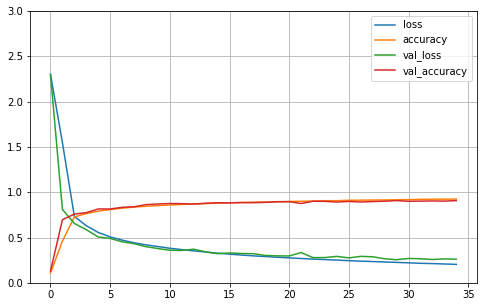

In [25]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()

plot_learning_curves(history)

In [23]:
model.evaluate(x_test_scaled, y_test, verbose = 0)

[0.28372910618782043, 0.9021999835968018]

在其他条件相同下,相较于常规的神经网络
1. 最终参数量:435306--184334
2. 收敛速度:变慢
3. 训练次数:20--35
1. 最终评估:loss稍稍增大,currency稍稍减少
>[0.2705853581428528, 0.9115999937057495]-->[0.28372910618782043, 0.9021999835968018]